# Depolarization of opinions

Let us consider a system of $N$ agents, each agent $i$
characterized by a dynamic opinion variable $x_i(t)$. For
the sake of simplicity, we consider opinions to be one dimensional,
with $x_i \in [-\infty;+\infty]$. The sign of the opinion
$x_i$, $\sigma(x_i)$, describes the agent's qualitative stance towards
 a binary issue of choice, such as the preference
between two candidates or a pro/con attitude in a controversial
topic. The absolute value of $x_i$, $|x_i|$, describes
the opinion's strength, or conviction, with respect to one
of the sides: the larger $|x_i|$, the more extreme the opinion
of agent $i$.

## Imports and settings

In [5]:
%reload_ext autoreload
%autoreload 2

import logging
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from matplotlib.ticker import MaxNLocator

from opdynamics.utils.distributions import negpowerlaw
import opdynamics.simulation as Simulation
from opdynamics.dynamics.echochamber import EchoChamber, NoisyEchoChamber, logger as eclogger
from opdynamics.visualise.visechochamber import VisEchoChamber
from opdynamics.visualise.dense import show_K_alpha_phase, show_activity_vs_opinion

from opdynamics.utils.constants import *


np.random.seed(1337)
sns.set_context("notebook")
logging.basicConfig(level=logging.DEBUG)
logging.getLogger('matplotlib').setLevel(logging.INFO)

# Example usage

## Parameters

In [6]:
num_agents = 1000
m = 10  # number of other agents to interact with
alpha = 3  # controversialness of issue (sigmoidal shape)
K = 3  # social interaction strength
epsilon = 1e-2  # minimum activity level with another agent
gamma = 2.1  # power law distribution param
beta = 3  # power law decay of connection probability
r = 0.5 # probability of a mutual interaction
activity_distribution = negpowerlaw

## Create EchoChamber

In [12]:
ec = EchoChamber(num_agents, m, K, alpha)
vis = VisEchoChamber(ec)

## Set activity based on powerlaw distribution

$$ F(a) = \frac{1 - γ}{1 - ε^{1 - γ}} a^{-\gamma} \tag{1}$$

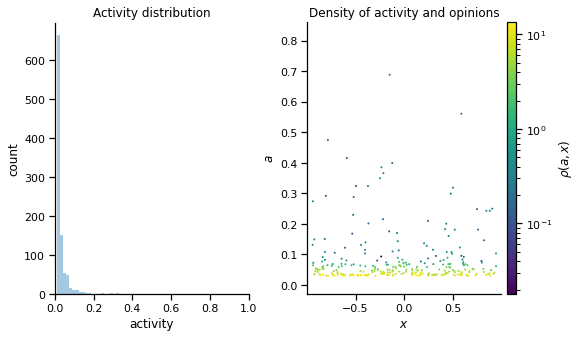

In [16]:
ec.set_activities(activity_distribution, gamma, epsilon)
fig, ax = plt.subplots(1,2, figsize=(8,5))
fig.subplots_adjust(wspace=0.3)
vis.show_activities(ax=ax[0])
vis.show_activity_vs_opinion(ax=ax[1])
sns.despine()

## Connection probabilities

$$ p_{ij} = \frac{|x_i - x_j|^{-\beta}}{\sum_j |x_i - x_j|^{-\beta}} \tag{2}$$

In [17]:
ec.set_connection_probabilities(beta=beta)

## Social Interactions
- adjacency matrix $A_{ij}(t)$ can be calculated before numerical integration (`lazy=False`) or at time $t$ (`lazy=True`).
- Cumulative adjacency matrix $\sum_{t=0}^T A_{ij}(t)$ can be plotted a number of ways using `vis.show_adjacency_matrix(...)`
    - `clustermap`
    - `heatmap`
    - `mesh`
    
    Interactions can be sorted using `sort=True` for plotting to identify clusters

DEBUG:social interaction:Social Interaction for echochamber initialised with r=0.5.
INFO:social interaction:eagerly computing 101 adjacency matrices...
101it [00:01, 62.62it/s]
DEBUG:social interaction:adjacency matrix has shape = (101, 1000, 1000)
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
C:\Users\Chris\Anaconda3\envs\opinion_dynamics\lib\site-packages\seaborn\matrix.py:624: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


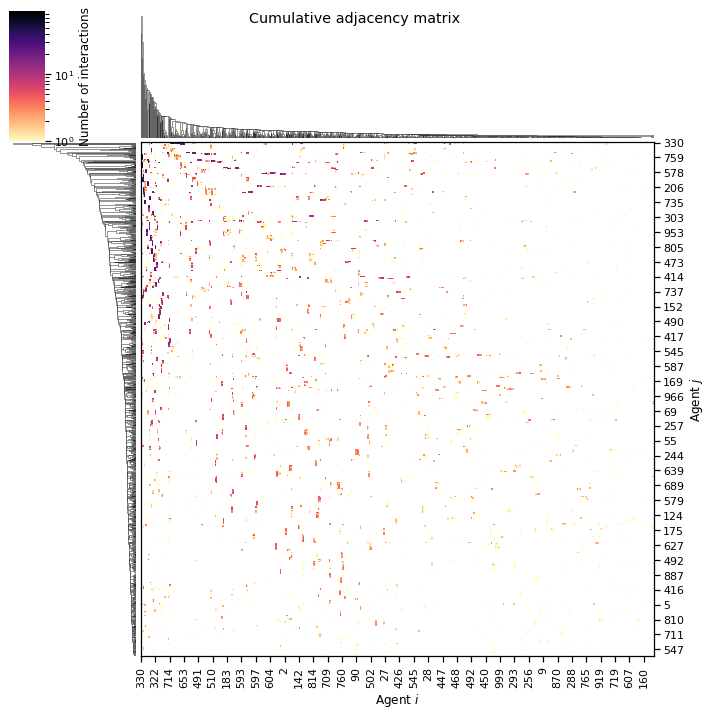

In [18]:
ec.set_social_interactions(0.5, lazy=False, t_end=1, dt=0.01)
vis.show_adjacency_matrix()
# keep a border around the main axis
sns.despine(top=False, right=False)

## Dynamics


Assuming that the opinion dynamics is solely
driven by the interactions among agents, we formulate
the model as $N$ coupled ordinary differential equations,

$$ \dot{x_i} = -x_i + K \sum_{j=1}^{N} A_{ij}(t) \tanh(\alpha x_j) \tag{3}$$

where K > 0 denotes the social interaction strength
among agents and $\alpha$ determines the sigmoidal shape of
the hyperbolic tangent. The opinion of an agent $i$ follows
the aggregated social input from the set of his/her neighbors
at time $t$, determined by the symmetric adjacency
matrix of the temporal network $A_{ij}(t)$, where $A_{ij}(t) = 1$
if agents $i$ and $j$ are interacting at time $t$, $A_{ij}(t) = 0$
otherwise. A similar model with static connectivity has
previously been used to describe the dynamics of neural
networks showing a transition from stationary to chaotic
phase [30].
The parameter $\alpha > 0$ tunes the degree of non-linearity
between an agent's opinion and the social influence s/he exerts on others.

In [19]:
ec.set_dynamics()

## Run and plot results

In [20]:
ec.run_network(dt=0.01, t_end=0.5, method='Euler')

INFO:solvers:solving ODE using Euler
INFO:solvers:51 iterations to do...
51it [00:00, 113.33it/s]
INFO:echo chamber:done running echochamber


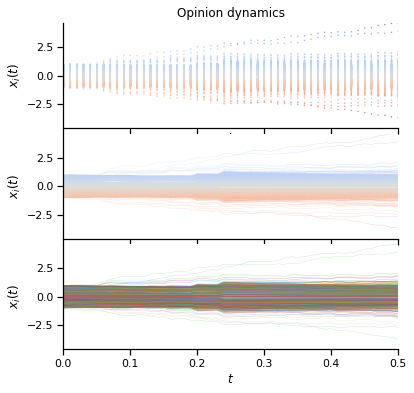

In [21]:
# some options on how to plot
fig, ax = plt.subplots(nrows=3, sharex='col', sharey='col', figsize=(6,6))
fig.subplots_adjust(hspace=0.05)
vis.show_opinions(color_code=True, ax=ax[0], title=True)    # markers
vis.show_opinions(color_code='line', ax=ax[1], title=False)  # lines (slowest)
vis.show_opinions(color_code=False, ax=ax[2], title=False)   # agents uniquely coloured
sns.despine(fig)

# Example results

> The convenient `Simulation.run_params` static method is used.

In [22]:
# General params

N=1000
m=10
T=10
epsilon=1e-2
gamma=2.1
r=0.5 # probability of mutual interaction
dt=0.01

# Specific params for different dynamics
param_set={
    "neutral": dict(K=3,alpha=0.05,beta=2),
    "radical": dict(K=3,alpha=3,beta=0),
    "polar": dict(K=3,alpha=3,beta=3)
    }

## Neutral opinion

- $K = 3$
- $\alpha = 0.05$
- $beta = 2$

DEBUG:simulation:run_params for EchoChamber with (N=1000, m=10, K=3, alpha=0.05, beta=2, activity =<class 'opdynamics.utils.distributions.negpowerlaw'>(epsilon=0.01, gamma=2.1), dt=0.01, T=10, r=0.5, plot_opinion=True, lazy=False)
DEBUG:simulation:additional args=()	additional kwargs={}
DEBUG:social interaction:Social Interaction for echochamber initialised with r=0.5.
INFO:social interaction:eagerly computing 1001 adjacency matrices...
1001it [00:17, 56.26it/s]
DEBUG:social interaction:adjacency matrix has shape = (1001, 1000, 1000)
INFO:echo chamber:done running echochamber
DEBUG:simulation:plotting


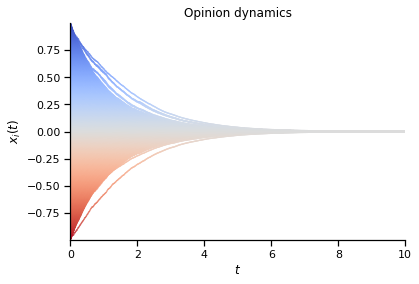

In [23]:
ec_neutral = Simulation.run_params(EchoChamber, N=N, m=m, **param_set['neutral'],
                                   activity=activity_distribution, epsilon=epsilon, gamma=gamma,
                                   dt=0.01, T=T, r=r,
                                   plot_opinion=True)
sns.despine()

## Radicalisation of opinions

- $K = 3$
- $\alpha = 3$
- $beta = 0$

DEBUG:simulation:run_params for EchoChamber with (N=1000, m=10, K=3, alpha=3, beta=0, activity =<class 'opdynamics.utils.distributions.negpowerlaw'>(epsilon=0.01, gamma=2.1), dt=0.01, T=10, r=0.5, plot_opinion=True, lazy=False)
DEBUG:simulation:additional args=()	additional kwargs={}
DEBUG:social interaction:Social Interaction for echochamber initialised with r=0.5.
INFO:social interaction:eagerly computing 1001 adjacency matrices...
1001it [00:14, 70.50it/s]
DEBUG:social interaction:adjacency matrix has shape = (1001, 1000, 1000)
INFO:echo chamber:done running echochamber
DEBUG:simulation:plotting


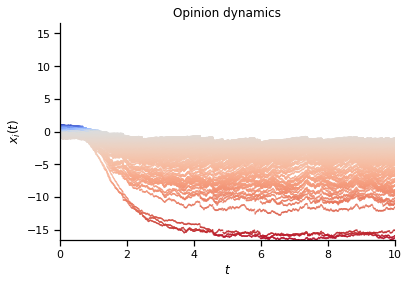

In [24]:
ec_radical = Simulation.run_params(EchoChamber, N=N, m=m, **param_set['radical'],
                                   activity=activity_distribution, epsilon=epsilon, gamma=gamma,
                                   dt=0.01, T=T, r=r,
                                   plot_opinion=True)
sns.despine()

## Polarisation of opinions

- $K = 3$
- $\alpha = 3$
- $beta = 3$

DEBUG:simulation:run_params for EchoChamber with (N=1000, m=10, K=3, alpha=3, beta=3, activity =<class 'opdynamics.utils.distributions.negpowerlaw'>(epsilon=0.01, gamma=2.1), dt=0.01, T=10, r=0.5, plot_opinion=True, lazy=False)
DEBUG:simulation:additional args=()	additional kwargs={}
DEBUG:social interaction:Social Interaction for echochamber initialised with r=0.5.
INFO:social interaction:eagerly computing 1001 adjacency matrices...
1001it [00:18, 55.41it/s]
DEBUG:social interaction:adjacency matrix has shape = (1001, 1000, 1000)
INFO:echo chamber:done running echochamber
DEBUG:simulation:plotting


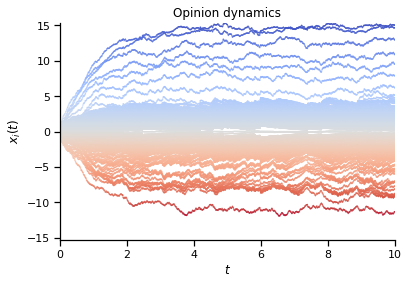

In [25]:
ec_polar = Simulation.run_params(EchoChamber, N=N, m=m, **param_set['polar'],
                                 activity=activity_distribution, epsilon=epsilon, gamma=gamma,
                                 dt=0.01, T=T, r=r,
                                 plot_opinion=True)
sns.despine()

## Compare opinons

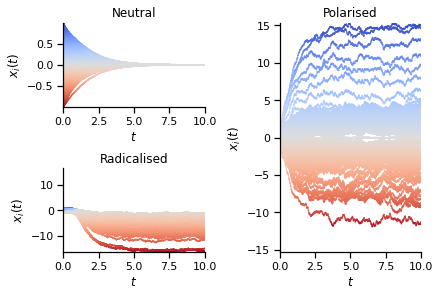

In [26]:
fig = plt.figure(constrained_layout=True)
spec = gridspec.GridSpec(nrows=2, ncols=2, figure=fig)
f_ax1 = fig.add_subplot(spec[0, 0]) # top left
f_ax2 = fig.add_subplot(spec[1, 0]) # bottom left
f_ax3 = fig.add_subplot(spec[:, 1]) # right column

VisEchoChamber(ec_neutral).show_opinions(ax=f_ax1, title="Neutral")
VisEchoChamber(ec_radical).show_opinions(ax=f_ax2, title="Radicalised")
VisEchoChamber(ec_polar).show_opinions(ax=f_ax3, title="Polarised")
sns.despine()

# Plot types

## $K-\alpha$ phase space

- $K \in [0,4]$
- $\alpha \in [0,4]$

with
- $beta = 0.5$
- $r = 0.5$


In [27]:
import os
import gc
from tqdm import tqdm
eclogger.setLevel(logging.DEBUG)

beta = 0.5
r = 0.5


# how many simulations to run
num_states = 8
start = 0
stop = 4
K_range = np.round(np.linspace(start,stop,num_states), 2)
alpha_range = np.round(np.linspace(start,stop,num_states), 2)


# where to save the file
file_name = "K-alpha-phase.h5"

# the efficient HDF format is used for saving and loading DataFrames.
if os.path.exists(file_name):
    df = pd.read_hdf(file_name)
else:
    df = pd.DataFrame(index=K_range, columns=alpha_range, dtype=float)
    for K,alpha in tqdm(itertools.product(K_range,alpha_range)):
        ec = Simulation.run_params(EchoChamber,N=N, m=m, K=K, alpha=alpha, beta=beta, 
                                   activity=activity_distribution, epsilon=epsilon, gamma=gamma,
                                   dt=dt, T=T, r=r,
                                   lazy=True, plot_opinion=True)
        t, mu = ec.get_mean_opinion(-1)
        df.loc[K, alpha] = mu
        # clear some memory
        del ec
        gc.collect()
    df.to_hdf(file_name, key='df')


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1f1b6129ac8>)

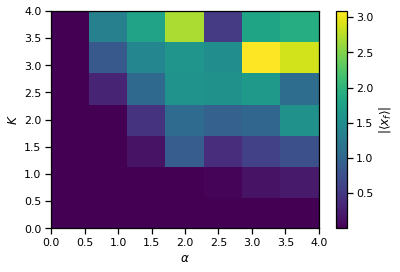

In [28]:
show_K_alpha_phase(df)

## Activity vs Opinion

- $K = 2$
- $\alpha = 3$
- $\beta = 1$
- $r = 0.65$

> to reproduce the density in the papers, $10^3$ "opinion states" need to be plotted, with each opinion state consisting of 1000 agents' opinions.

In [29]:
from tqdm import tqdm

# suppress logging for clean progressbar
logging_level = logging.getLogger().getLevel()
logging.getLogger().setLevel(logging.WARNING)

# parameters
N=1000
m=10
T=5
activity_distribution=negpowerlaw
epsilon=1e-2
gamma=2.1
dt=0.01
K=2
beta=1
alpha=3
r=0.65

# how many simulations to run
num_states = 100

# where to save the file
file_name = "activity_vs_opinion.h5"

# helper array
agent_indices = np.arange(N, dtype=int)

# the efficient HDF format is used for saving and loading DataFrames.
with pd.HDFStore(file_name) as hdf:
    # get keys from the store to know how many simulations have already been saved
    states = hdf.keys()
    states_completed = len(states)
    # we start iterating from states_completed as the `seed` parameter uses `i`
    for i in tqdm(range(states_completed, num_states)):
        ec = Simulation.run_params(EchoChamber,N,m,K,alpha,beta,
                                   activity_distribution,epsilon,gamma,dt,T,r,lazy=True,
                                   seed=i)
        # create dataframe for this iteration
        df = pd.DataFrame({"activity": ec.activities,
                           "opinion": ec.opinions
                          })
        # save to disk for use later
        hdf.append(f"d{i}", df)

# return to previous logging (more or less - we change root level)
logging.getLogger().setLevel(logging_level)


AttributeError: 'RootLogger' object has no attribute 'getLevel'

In [ ]:
# collect all data into a dataframe
with pd.HDFStore(file_name) as hdf:
    df_ao = pd.concat([hdf.get(key) for key in hdf.keys()])
df_ao.shape

In [ ]:
# plot everything
fig, ax = show_activity_vs_opinion(df_ao.opinion.values, df_ao.activity.values)
ax.set_ylim(0, 0.5)
sns.despine()

In [ ]:
# clear up some ram
del df_ao

## Show adjacency matrix

In [ ]:
vis.show_adjacency_matrix("clustermap", ax=False, fig=False, sort=False)
fig, ax = plt.subplots(2, 1, figsize=(10,20))
vis.show_adjacency_matrix("heatmap", sort=True, square=True, ax=ax[0])
vis.show_adjacency_matrix("mesh", sort=True, ax=ax[1])


## Agent opinons at $t$

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10,10), sharex=True)
fig.subplots_adjust(hspace=0.3)
vis.show_agent_opinions(direction=True, sort=True, ax=ax[0])
vis.show_opinions_snapshot(ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticks())
sns.despine()

## Nearest Neighbour

In [ ]:
g = vis.show_nearest_neighbour()
# adjust limits based on xaxis
from scipy import stats
x_data, y_data = g.ax_marg_x.get_lines()[0].get_data()
s = stats.describe(y_data)
low_bound = np.max(s.mean-s.variance, 0)
mask = (low_bound < y_data)
lim = x_data[mask][0]*1.5, x_data[mask][-1]*1.5
g.ax_joint.set_xlim(*lim)
# keep it 'square' (xlim == ylim)
g.ax_joint.set_ylim(*lim)

In [ ]:
# try "paper" "poster" "talk" or "notebook"
with sns.plotting_context("notebook"):
    fig, ax = vis.show_summary(fig_kwargs=dict(figsize=(12,12), constrained_layout=False))
fig.subplots_adjust(wspace=0.5, hspace=0.5)
sns.despine()

# Noisy Echo Chamber

In [ ]:
N=1000
m=10
T=10
epsilon=1e-2
gamma=2.1
dt=0.01
K=2
beta=1
alpha=3
r=0.65

D_range = [0, 0.01, 0.1, 1, 10]
nec_arr = Simulation.run_noise_range(D_range)

In [ ]:
fig, ax = plt.subplots(nrows=len(D_range), ncols=2, sharex=True, sharey='col', figsize=(8, 11))

with sns.plotting_context("notebook"):
    for i, (vis, _ax) in enumerate(zip(vis_arr, ax)):
        # 0 is first column, 1 is 2nd column
        vis.show_opinions(ax=_ax[0], title=(i==0))
        vis.show_opinions_snapshot(ax=_ax[1], title=(i==0))
        if i!=len(vis_arr)-1:
            _ax[0].set_xlabel("")
            _ax[1].set_xlabel("")
        _ax[0].annotate(vis.ec.name, fontsize='x-large',
                        xy=(0.01, 1.05), xycoords='axes fraction', 
                        ha="left", va="top", rotation=0)
sns.despine()
plt.show()

## Delayed noise

In [ ]:
logging.getLogger().setLevel(logging.DEBUG)
N=1000
m=10
activity_distribution = negpowerlaw
epsilon=1e-2
gamma=2.1
dt=0.01
K=3
beta=3
alpha=3
r=0.65

D=0.1

noise_start = 10.
noise_length = 10.
recovery = 10.
lazy=True


In [ ]:
nec = Simulation.run_periodic_noise(noise_start, noise_length, recovery,
                                    N,m,K,alpha,beta,activity_distribution,epsilon,gamma,dt,r=r,
                                    D=D,lazy=lazy)
vis = VisEchoChamber(nec)

In [ ]:
vis.show_adjacency_matrix("mesh", sort=True)

In [ ]:
with sns.plotting_context("paper"):
    from matplotlib import gridspec
    fig = plt.figure(figsize=(8,6))
    gs = gridspec.GridSpec(nrows=3, ncols=3, figure=fig, wspace=0.3, hspace=0.8)
    ax_time = fig.add_subplot(gs[0:2,:])
    ax_start = fig.add_subplot(gs[-1,0])
    ax_noise = fig.add_subplot(gs[-1,1], sharey=ax_start)
    ax_recovery = fig.add_subplot(gs[-1,2], sharey=ax_start)

    _colors = sns.color_palette("husl")

    vis.show_opinions(ax=ax_time, color_code='line', subsample=5, title=False)
    vis.show_opinions_snapshot(ax=ax_start, t=noise_start, title=f"t={noise_start}", 
                               color=_colors[0])
    vis.show_opinions_snapshot(ax=ax_noise, t=noise_start+noise_length, title=f"t={noise_start+noise_length}",
                               color=_colors[1])
    vis.show_opinions_snapshot(ax=ax_recovery, t=-1, title=f"t={noise_start+noise_length+recovery}",
                               color=_colors[2])

    ax_time.set_ylim(-10, 10)
    ax_start.set_xlim(-10,10)
    ax_noise.set_xlim(-10,10)
    ax_recovery.set_xlim(-10,10)
    ylim = ax_time.get_ylim()
    ax_time.vlines(x=[noise_start,noise_start+noise_length,noise_start+noise_length+recovery], 
                   ymin=ylim[0], ymax=ylim[1], color=_colors)
    ax_time.annotate(f"noise = {D}", xy=(noise_start, ylim[1]), ha='left', va='bottom')
    ax_time.annotate(f"noise = 0", xy=(noise_start+noise_length, ylim[1]), ha='left', va='bottom')
    ax_time.hlines(y=ylim[1], xmin=noise_start, xmax=noise_start+noise_length, lw=10, color='k')
    sns.despine()
    ax_noise.set_ylabel("")
    ax_recovery.set_ylabel("")
;

## TODO: Using Julia

`DiffentialEquations.jl`

Setup:

1. Download Julia and add `julia` to system path.
2. `pip install diffeqpy numba`

3. Install Python compatibility
    ```python
   import julia
   julia.install()
   import diffeqpy
   diffeqpy.install()
   ```
4. Test it works
   ```python
   from diffeqpy import de
   ```

### Julia Issues

Need to re-specify equation because of element-wise multiplication.
